In [1]:
!pip install yfinance

!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 35.0 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from tqdm import tqdm
from datetime import datetime, timedelta
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Define ticker symbols and date ranges
ticker = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-B', 'JPM', 'V']
start_date = '2010-01-01'
end_date = '2024-12-31'
train_end = '2023-12-31'
test_start = '2024-01-01'

# Download adjusted close data
data = yf.download(ticker, start=start_date, end=end_date)

# Keep only the 'Close' price for each ticker
close_data = data['Close'].copy()

# Compute log returns (or log prices)
log_close_data = np.log(close_data)

log_data = pd.concat([close_data, log_close_data], axis=1, keys=['Close', 'LogClose'])

# Optional: View the structure
print(log_data.head())


[*********************100%***********************]  10 of 10 completed

               Close                                                           \
Ticker          AAPL    AMZN      BRK-B      GOOGL        JPM META       MSFT   
Date                                                                            
2010-01-04  6.431896  6.6950  66.220001  15.590930  28.829178  NaN  23.211443   
2010-01-05  6.443019  6.7345  66.540001  15.522272  29.387602  NaN  23.218939   
2010-01-06  6.340532  6.6125  66.199997  15.130977  29.549063  NaN  23.076448   
2010-01-07  6.328811  6.5000  66.459999  14.778734  30.134409  NaN  22.836458   
2010-01-08  6.370887  6.6760  66.440002  14.975752  30.060387  NaN  22.993950   

                                      LogClose                                \
Ticker          NVDA TSLA          V      AAPL      AMZN     BRK-B     GOOGL   
Date                                                                           
2010-01-04  0.423854  NaN  19.719204  1.861269  1.901361  4.192983  2.746689   
2010-01-05  0.430044  NaN  19.4

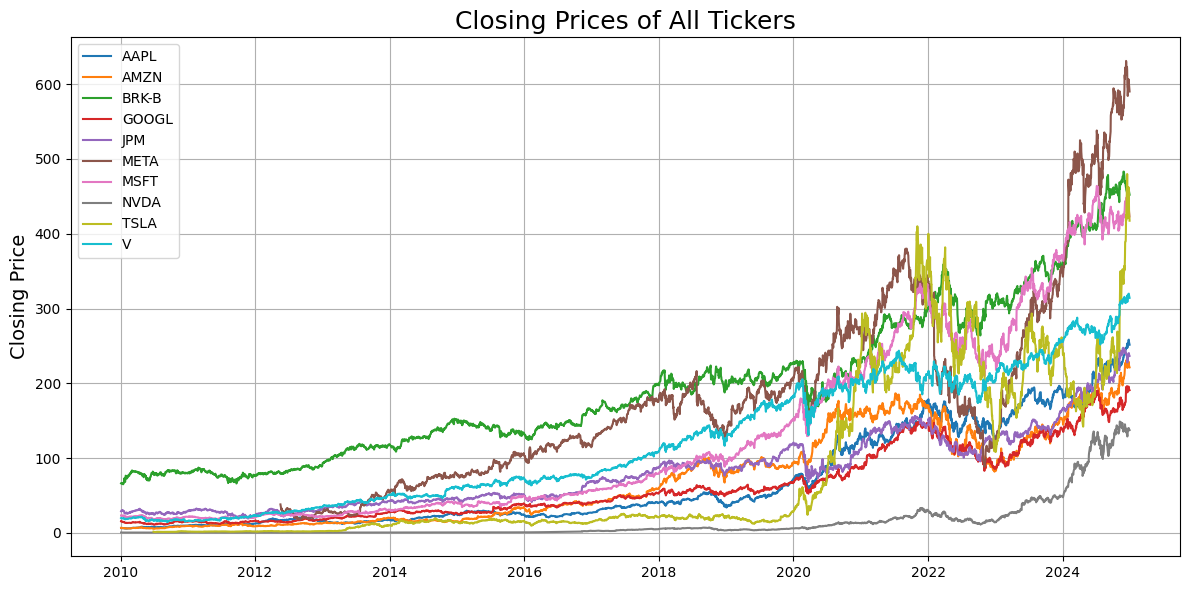

In [5]:
plt.figure(figsize=(12, 6))

for ticker in data['Close'].columns:
    plt.plot(data['Close'][ticker], label=ticker)

plt.ylabel('Closing Price', fontsize=14)
plt.title('Closing Prices of All Tickers', fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


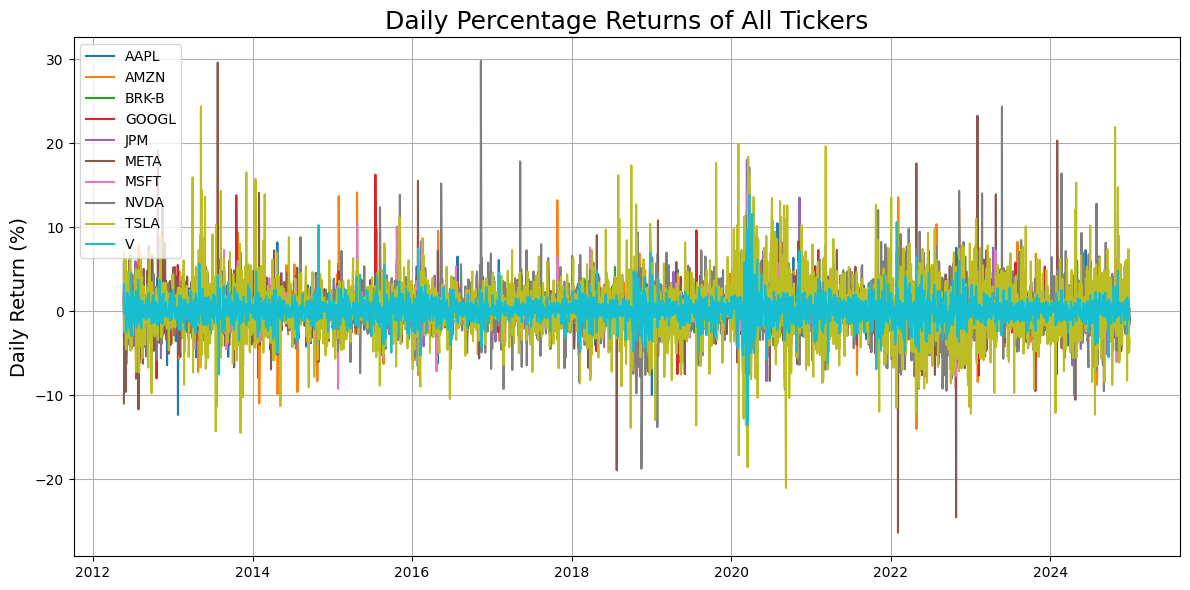

In [6]:
# daily simple returns in %
returns = data['Close'].pct_change().mul(100).dropna()

plt.figure(figsize=(12, 6))
for ticker in returns.columns:
    plt.plot(returns[ticker], label=ticker)

plt.ylabel('Daily Return (%)', fontsize=14)
plt.title('Daily Percentage Returns of All Tickers', fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
log_price = log_close_data.copy()
log_train = log_price.loc[:train_end].copy()
log_test = log_price.loc[test_start:].copy()

In [8]:
# Clean missing data
log_train = log_train.dropna()
log_test = log_test.dropna()


In [9]:
# 3. Rolling forecast setup
history = log_train.copy()
predictions = []
pred_index = []

In [10]:
from arch import arch_model
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Compute daily log returns (% scale for GARCH)
log_returns = log_data.diff().dropna() * 100

# 2. Split training set
train_end = '2023-12-31'
returns_train = log_returns.loc[:train_end]
returns_test = log_returns.loc[test_start:]

# 3. Define GARCH order grid
p_range = range(1, 6)
q_range = range(1, 6)

# 4. Storage for best model results
garch_summary = []

# 5. Grid search for each ticker (filter only LogClose)
logclose_cols = [col for col in log_returns.columns if 'LogClose' in str(col)]
clean_tickers = [col[1] if isinstance(col, tuple) else col for col in logclose_cols]

for col, ticker in tqdm(zip(logclose_cols, clean_tickers), total=len(logclose_cols), desc="GARCH Grid Search"):
    r = returns_train[col].dropna()

    best_bic = np.inf
    best_order = None

    for p in p_range:
        for q in q_range:
            try:
                am = arch_model(r, vol='GARCH', p=p, q=q, mean='Constant', rescale=False)
                res = am.fit(disp='off')
                bic = res.bic

                if bic < best_bic:
                    best_bic = bic
                    best_order = (p, q)
            except Exception:
                continue

    garch_summary.append({
        'Ticker': ticker,
        'Best_BIC_Order': best_order,
        'Best_BIC': best_bic
    })

garch_summary_df = pd.DataFrame(garch_summary)

print("\n✅ Best GARCH(p,q) Models by BIC:\n")
print(garch_summary_df)


GARCH Grid Search: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


✅ Best GARCH(p,q) Models by BIC:

  Ticker Best_BIC_Order      Best_BIC
0   AAPL         (1, 1)  11219.403181
1   AMZN         (1, 1)  12047.869252
2  BRK-B         (1, 1)   8434.537928
3  GOOGL         (1, 2)  11048.628440
4    JPM         (1, 1)  10345.453022
5   META         (2, 2)  13284.126475
6   MSFT         (1, 1)  10775.353535
7   NVDA         (4, 2)  13790.135312
8   TSLA         (1, 1)  15319.939276
9      V         (1, 1)  10060.484254


In [11]:
# 2. Compute log prices and daily log returns (%)
log_close_data = np.log(close_data)
log_returns = log_close_data.diff().dropna() * 100  # Returns in percent

# 3. Split train and test sets
returns_train = log_returns.loc[:train_end]
returns_test = log_returns.loc[test_start:]

In [12]:
# 5. Rolling Forecast
forecast_results = []

for _, row in tqdm(garch_summary_df.iterrows(), total=garch_summary_df.shape[0], desc="Rolling Forecast"):
    ticker = row['Ticker']
    best_p, best_q = row['Best_BIC_Order']

    train_series = returns_train[ticker].dropna()
    test_series = returns_test[ticker].dropna()

    rolling_forecast = []

    for i in range(len(test_series)):
        combined = pd.concat([train_series, test_series.iloc[:i]])
        try:
            am = arch_model(combined, vol='GARCH', p=best_p, q=best_q, mean='Constant', rescale=False)
            res = am.fit(disp='off')
            forecast = res.forecast(horizon=1)
            variance = forecast.variance.values[-1, 0]
            rolling_forecast.append(variance)
        except:
            rolling_forecast.append(np.nan)

    forecast_results.append(pd.DataFrame({
        'Date': test_series.index,
        'Ticker': ticker,
        'Actual': test_series.values,
        'Forecasted_Variance': rolling_forecast
    }))



Rolling Forecast: 100%|██████████| 10/10 [01:50<00:00, 11.04s/it]


In [13]:
# 6. Combine forecasts
rolling_df = pd.concat(forecast_results, ignore_index=True)
rolling_df['Forecasted_Std'] = np.sqrt(rolling_df['Forecasted_Variance'])

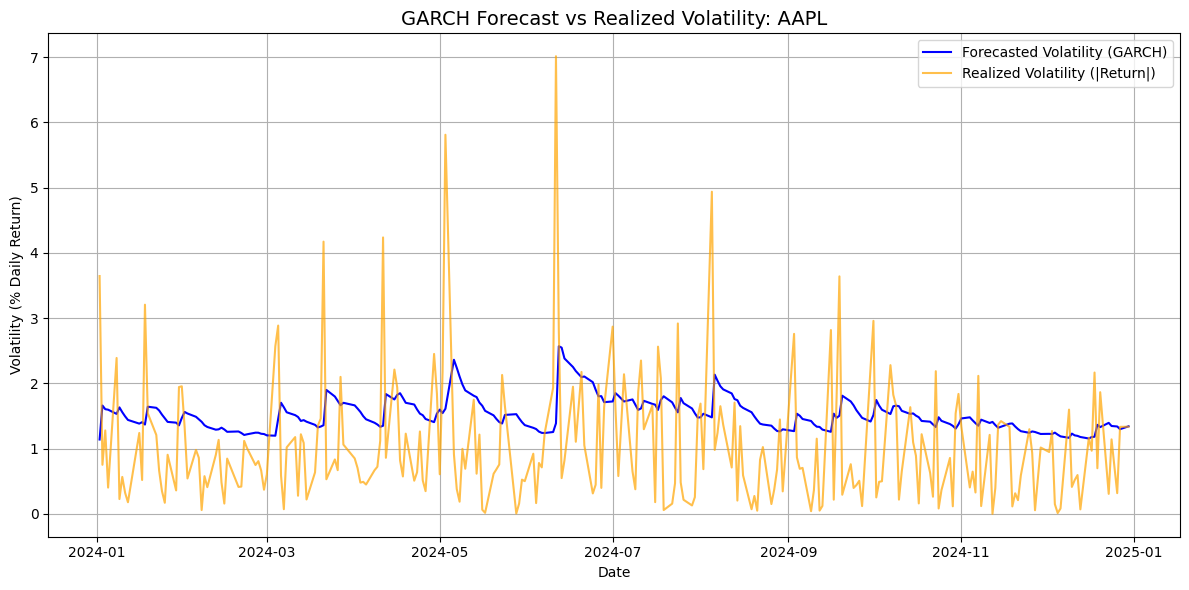

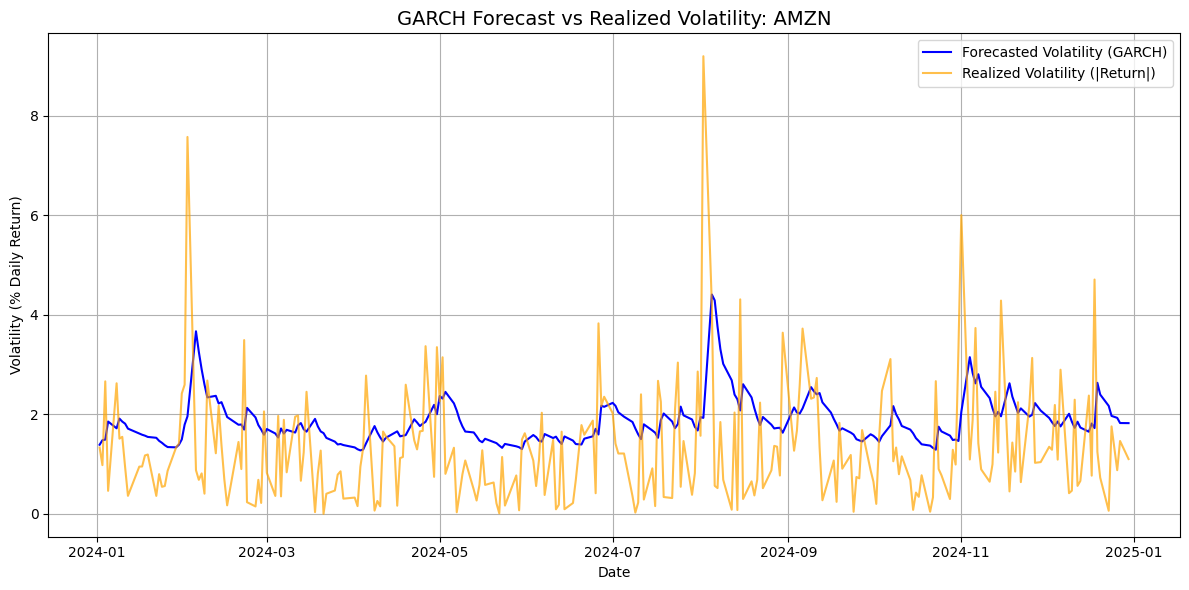

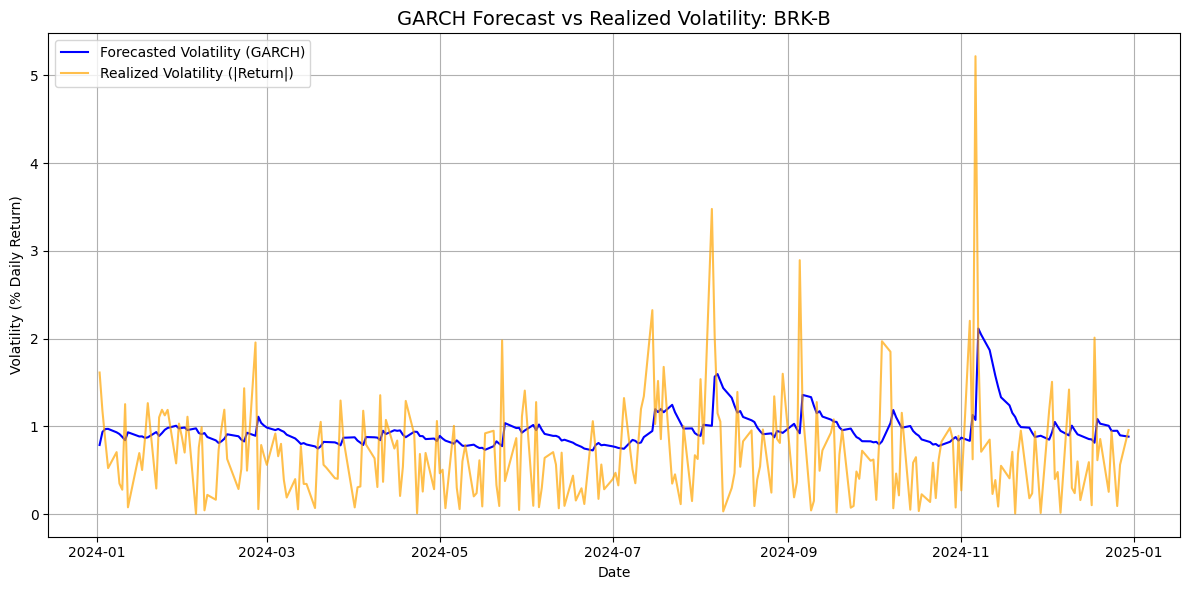

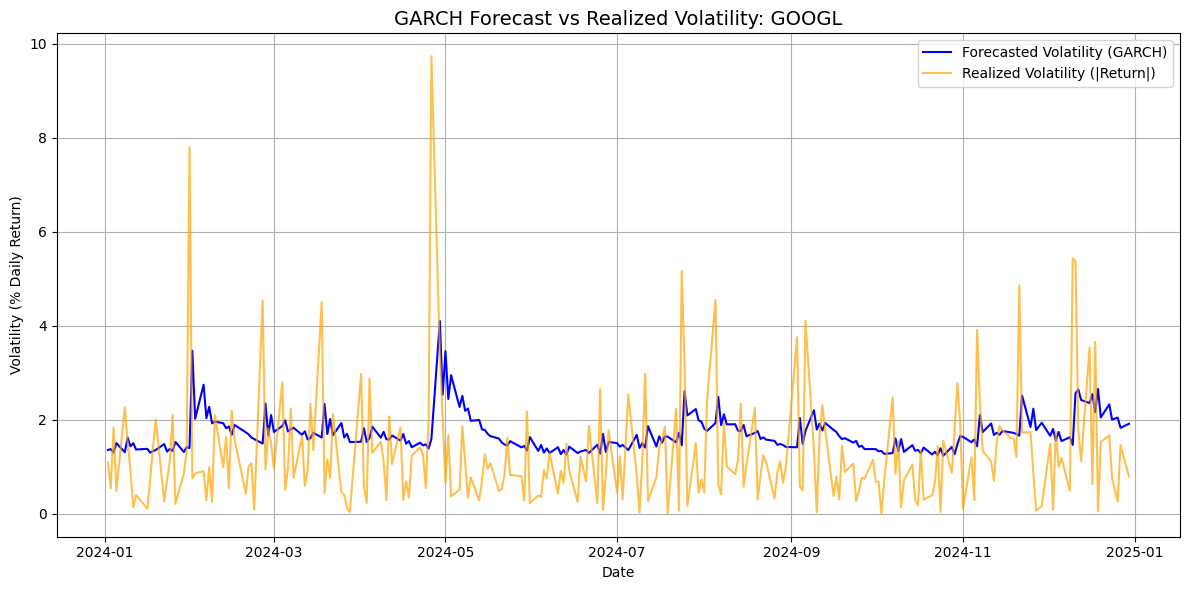

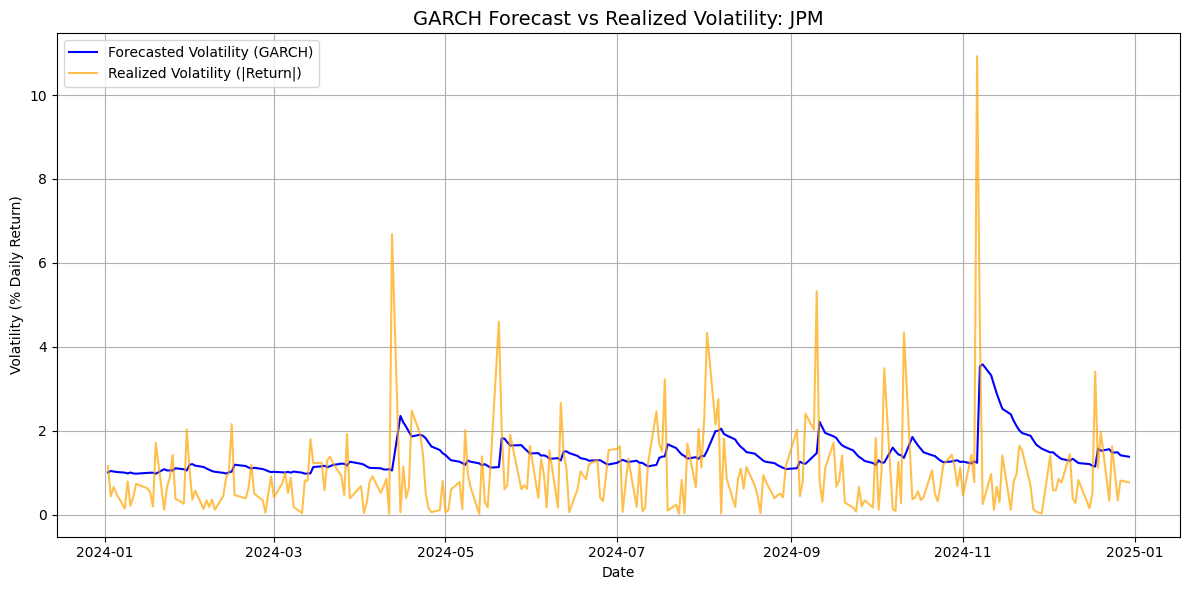

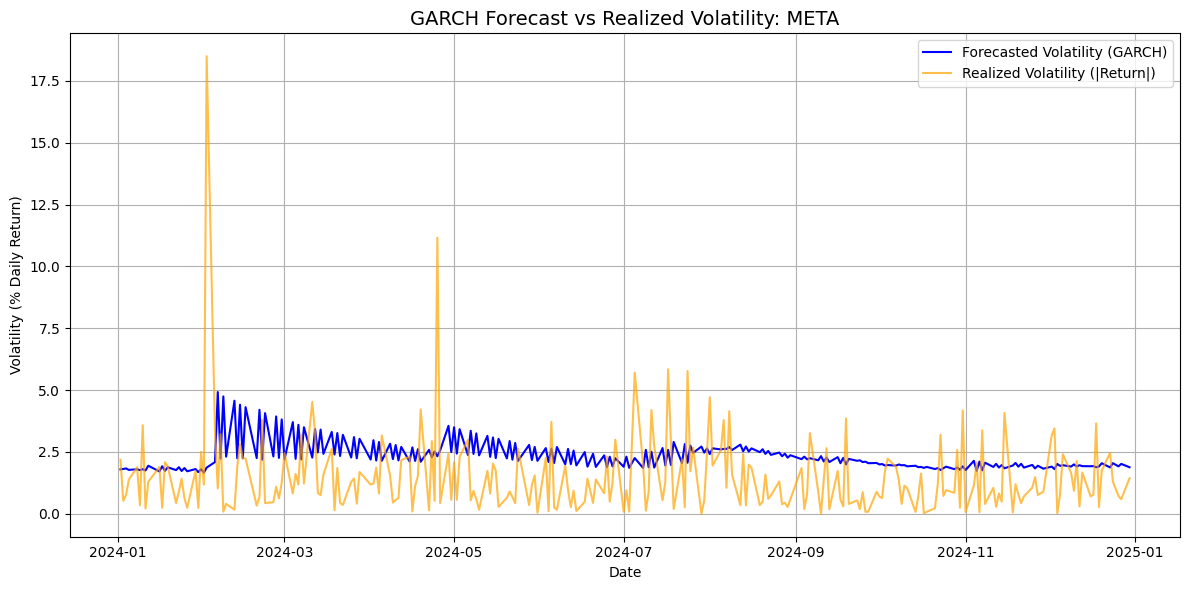

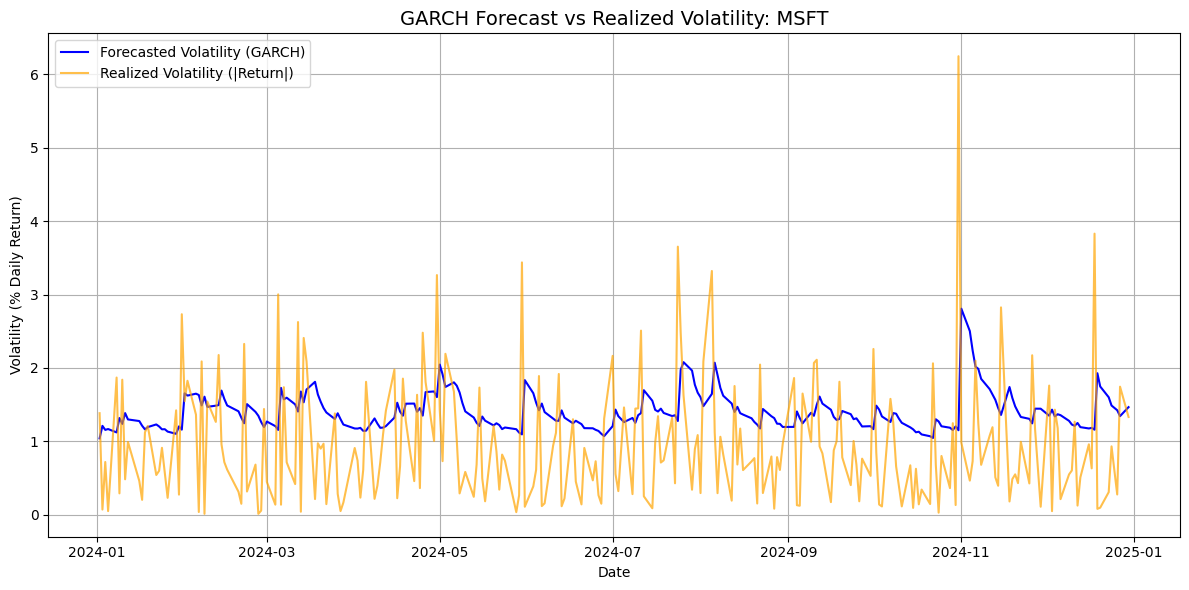

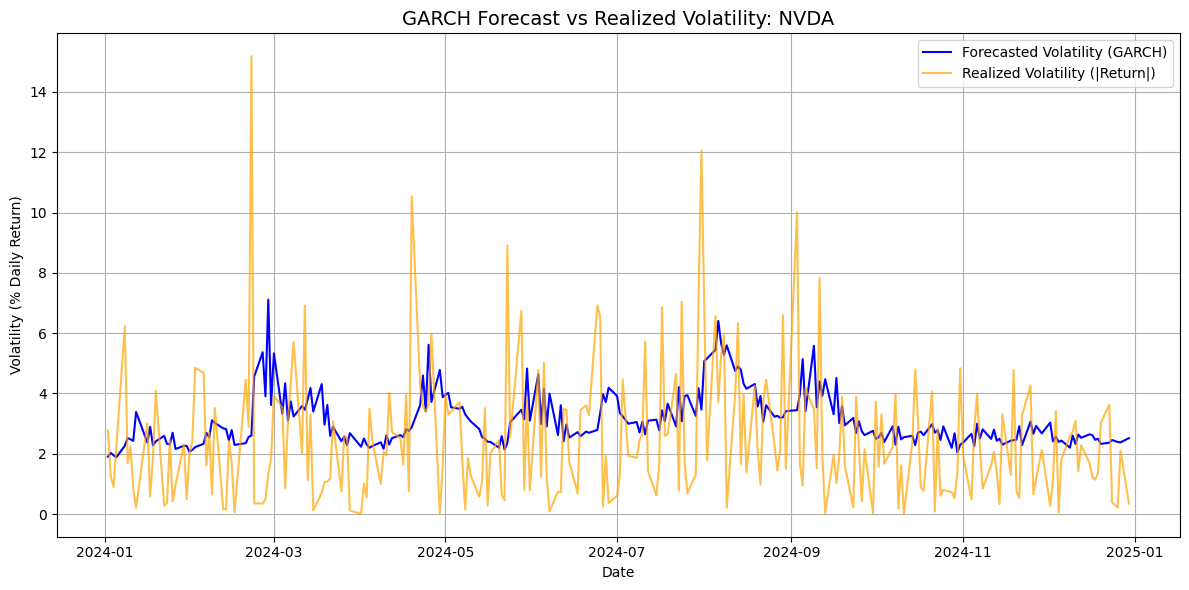

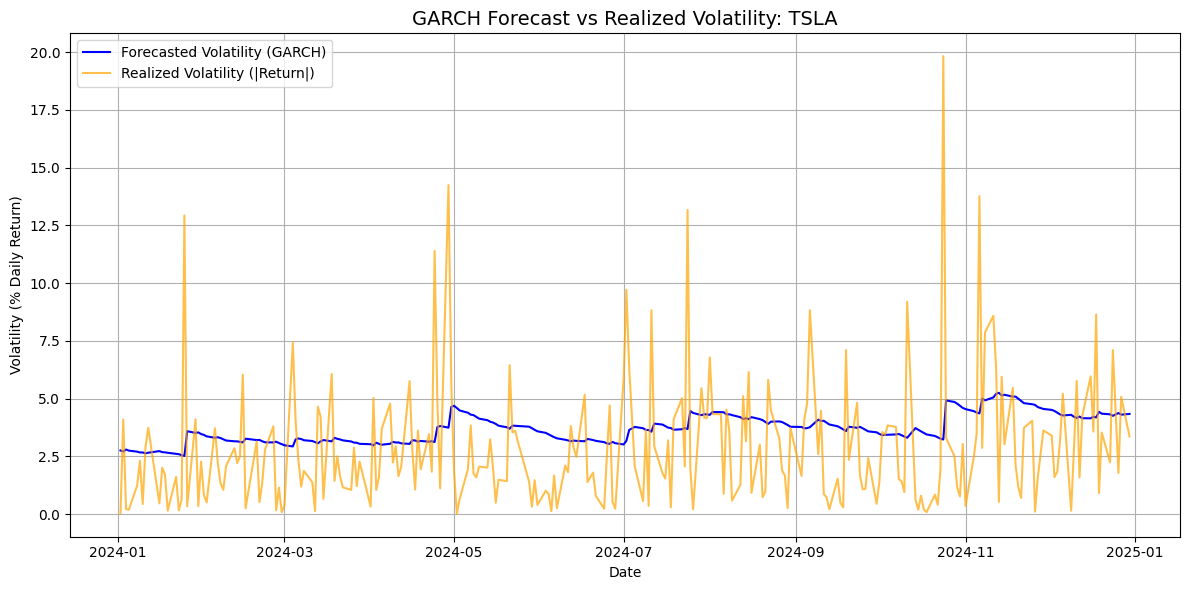

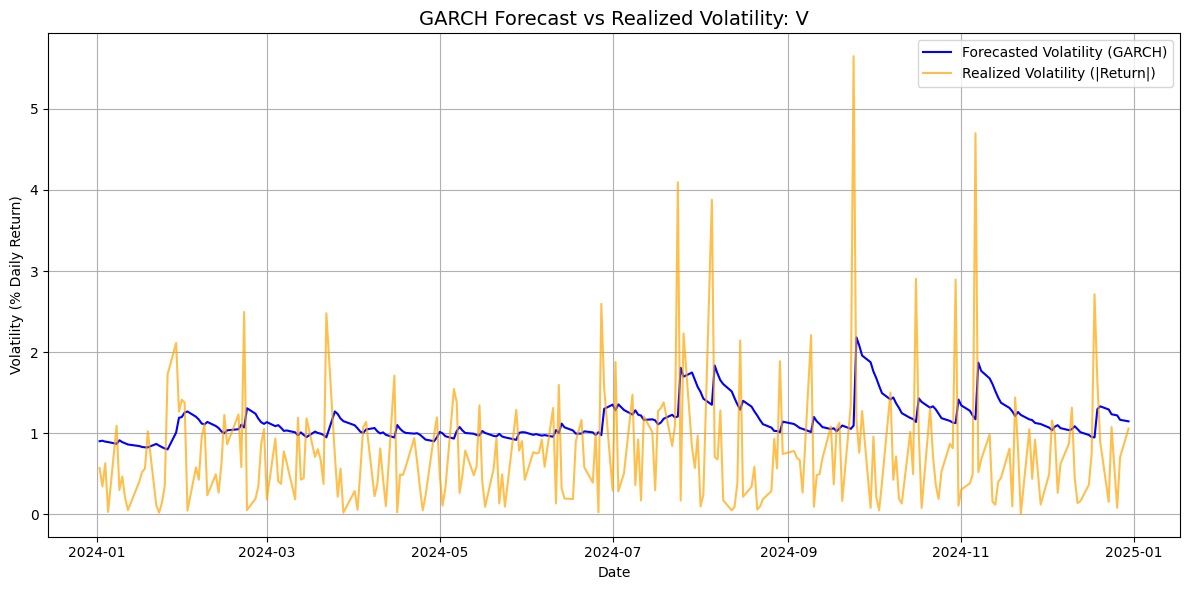

In [14]:
# 7. Plotting
unique_tickers = rolling_df['Ticker'].unique()

for ticker_to_plot in unique_tickers:
    plot_df = rolling_df[rolling_df['Ticker'] == ticker_to_plot].copy()
    plot_df.dropna(subset=['Forecasted_Std', 'Actual'], inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['Date'], plot_df['Forecasted_Std'], label='Forecasted Volatility (GARCH)', color='blue')
    plt.plot(plot_df['Date'], np.abs(plot_df['Actual']), label='Realized Volatility (|Return|)', color='orange', alpha=0.7)

    plt.title(f"GARCH Forecast vs Realized Volatility: {ticker_to_plot}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Volatility (% Daily Return)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
# Filter valid rows
rolling_df_clean = rolling_df.dropna(subset=['Actual', 'Forecasted_Std']).copy()
rolling_df_clean['Realized_Volatility'] = np.abs(rolling_df_clean['Actual'])

# Group by ticker and compute metrics
vol_forecast_metrics = rolling_df_clean.groupby('Ticker').apply(
    lambda df: pd.Series({
        'MAE': mean_absolute_error(df['Realized_Volatility'], df['Forecasted_Std']),
        'RMSE': np.sqrt(mean_squared_error(df['Realized_Volatility'], df['Forecasted_Std']))
    })
).reset_index()

# Show the result
print("\n📊 Forecast Evaluation Metrics (Daily Volatility %):")
print(vol_forecast_metrics)



📊 Forecast Evaluation Metrics (Daily Volatility %):
  Ticker       MAE      RMSE
0   AAPL  0.893044  1.109125
1   AMZN  1.060085  1.343764
2  BRK-B  0.516426  0.672194
3  GOOGL  1.004118  1.337315
4    JPM  0.879529  1.257845
5   META  1.506059  2.022648
6   MSFT  0.826185  0.990377
7   NVDA  1.767513  2.325948
8   TSLA  2.194289  2.874110
9      V  0.692889  0.881570


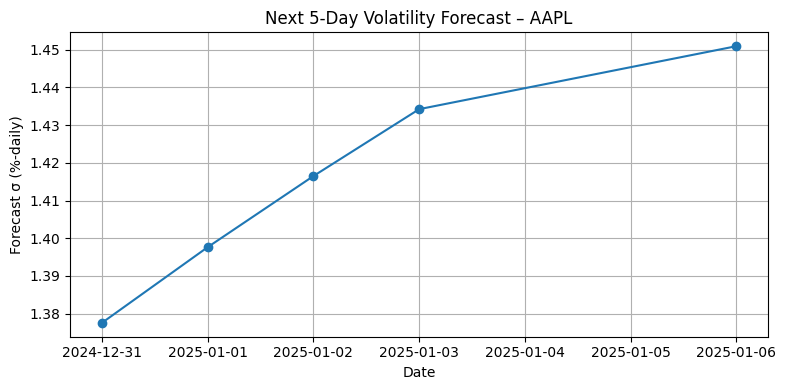

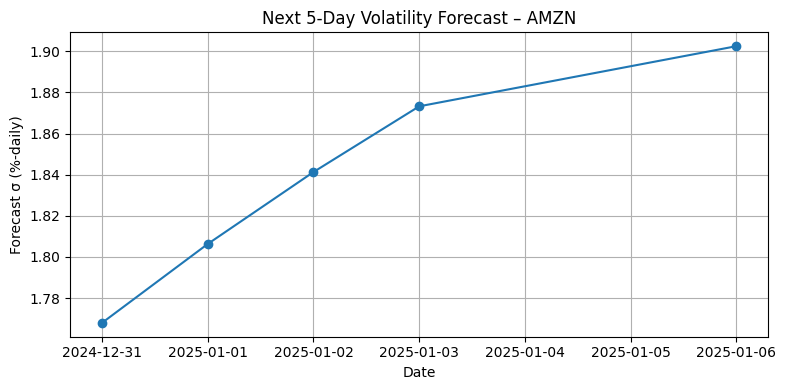

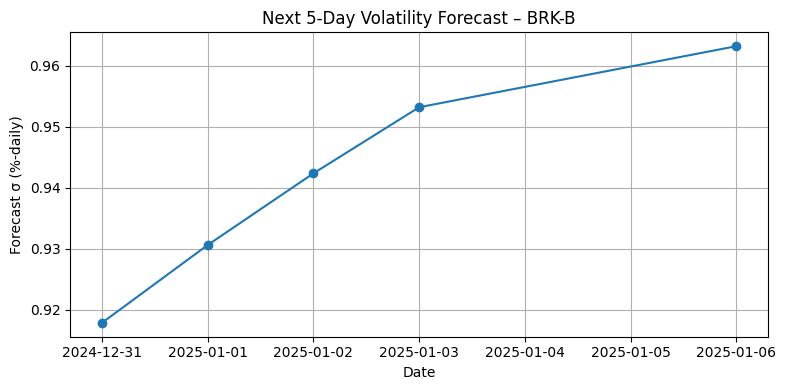

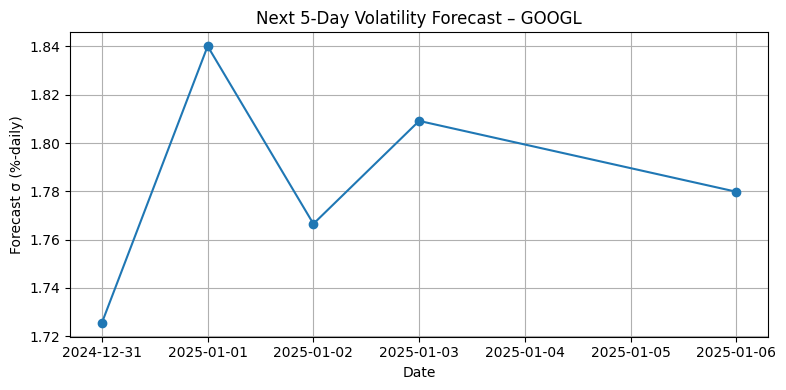

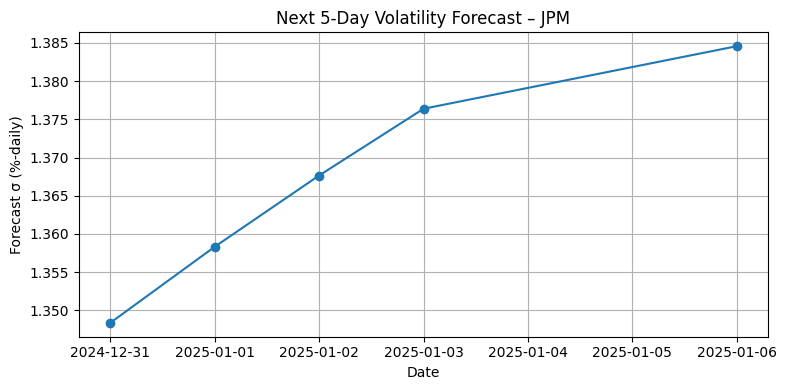

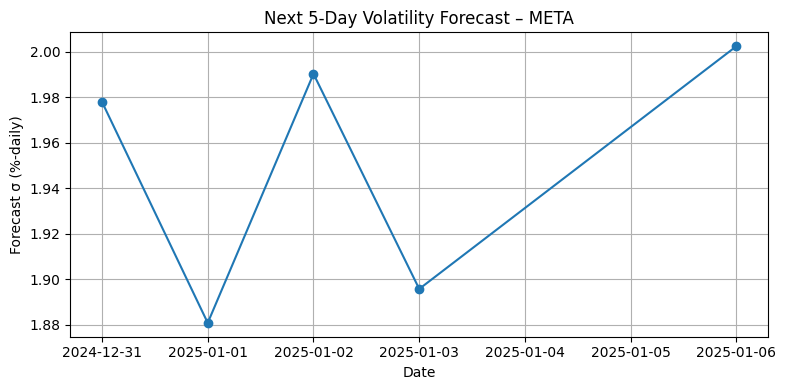

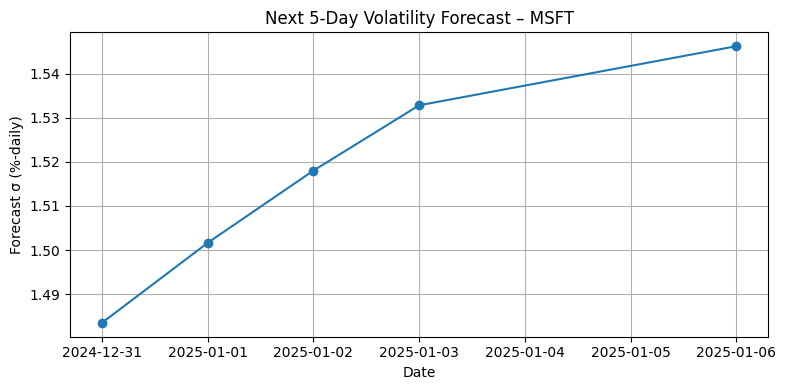

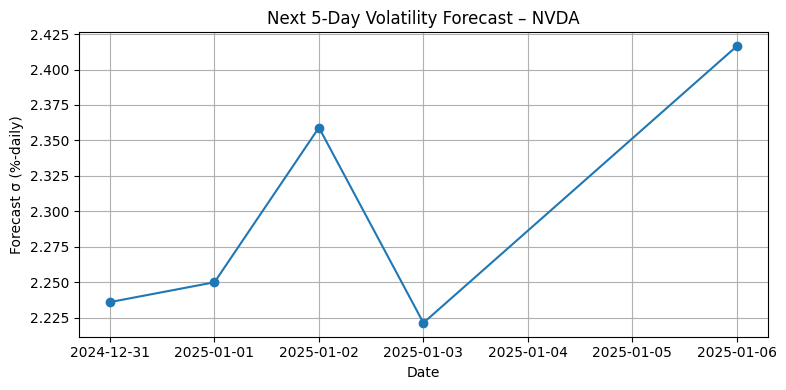

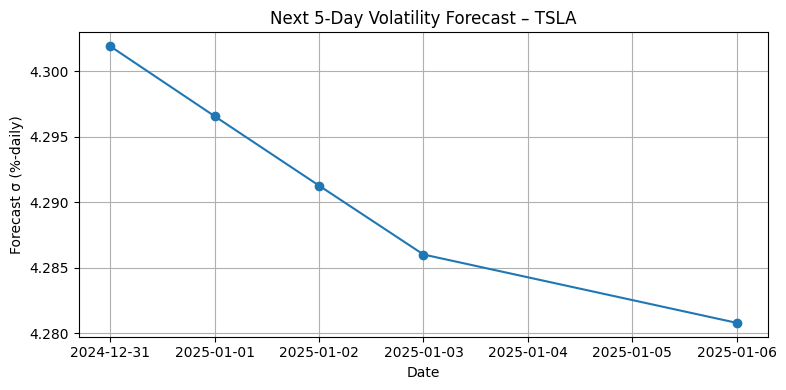

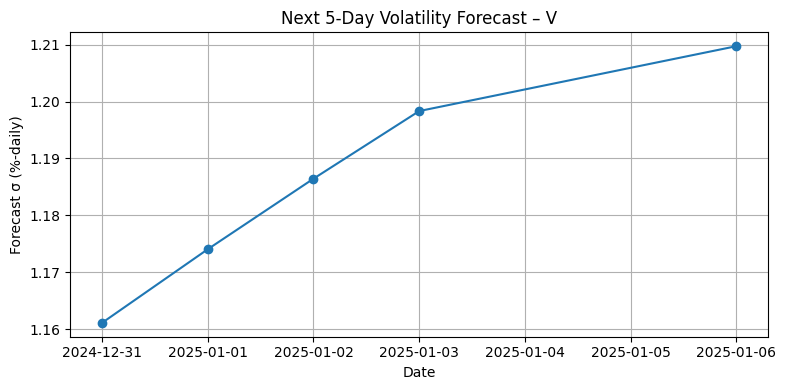

In [17]:
# === 5-day-ahead volatility forecast and plot =====================
from arch import arch_model
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

forecast_horizon = 5
last_obs         = log_returns.index[-1]
future_dates     = pd.bdate_range(last_obs + BDay(), periods=forecast_horizon)

for _, row in garch_summary_df.iterrows():
    tkr       = row['Ticker']
    p, q      = row['Best_BIC_Order']

    r         = log_returns[tkr].dropna()
    res       = arch_model(r, vol='GARCH', p=p, q=q,
                           mean='Constant', rescale=False).fit(disp='off')

    # daily conditional variances for the next 5 trading days
    var_vec   = res.forecast(horizon=forecast_horizon).variance.iloc[-1].values
    sigma_vec = np.sqrt(var_vec)                       # σ (% daily return)

    # --- plot ------------------------------------------------------
    plt.figure(figsize=(8,4))
    plt.plot(future_dates, sigma_vec, marker='o')
    plt.title(f'Next 5-Day Volatility Forecast – {tkr}')
    plt.xlabel('Date'); plt.ylabel('Forecast σ (%-daily)')
    plt.grid(True); plt.tight_layout()
    plt.show()
